In [1]:
'''
시계열 single
'''

'\n시계열 single\n'

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
raw_df = sns.load_dataset("flights")
raw_df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [4]:
'''1. 전처리'''

'1. 전처리'

In [5]:
df = raw_df.copy()
df['date'] = pd.to_datetime(df['year'].astype(str) + df['month'].astype(str), format='%Y%b')
df = df.set_index('date').loc[:,'passengers']
df = df.sort_index()
df.head()

date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: passengers, dtype: int64

In [6]:
full_date = pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS')
full_date.difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='MS')

In [7]:
train_data = df.head(-24)
test_data = df.tail(24)

In [8]:
'''2. 시각화'''

'2. 시각화'

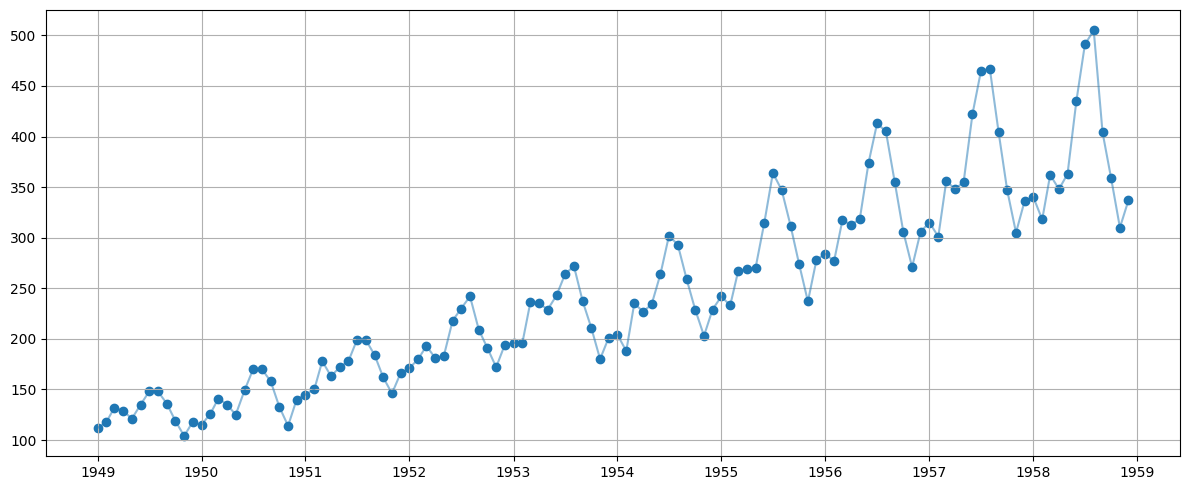

In [9]:
plt.figure(figsize=(12, 5))
plt.scatter(train_data.index, train_data)
plt.plot(train_data.index, train_data, alpha=0.5)
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
'''3. 정규성 검토'''

'3. 정규성 검토'

In [11]:
from statsmodels.tsa.stattools import adfuller

'''
데이터가 추세를 보이지 않는다 -> regression = 'nc' or 'c'
데이터가 추세를 보인다 -> regression = 'ct' or 'ctt'
'''

H0 = '데이터가 정상성을 만족하지 않는다'
H1 = '데이터가 정상성을 만족한다'

adf = adfuller(train_data, regression='ct')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
if adf[1] < 0.05:
    print(H1)
else:
    print(H0)

ADF Statistic: -2.299989527153969
p-value: 0.43395567906461285
데이터가 정상성을 만족하지 않는다


In [12]:
# 1차 차분
H0 = '데이터가 정상성을 만족하지 않는다'
H1 = '데이터가 정상성을 만족한다'

adf = adfuller(train_data.diff().dropna(), regression='ct')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
if adf[1] < 0.05:
    print(H1)
else:
    print(H0)

ADF Statistic: -1.9292873745649592
p-value: 0.6393606646017381
데이터가 정상성을 만족하지 않는다


In [13]:
# 2차 차분
H0 = '데이터가 정상성을 만족하지 않는다'
H1 = '데이터가 정상성을 만족한다'

adf = adfuller(train_data.diff().diff().dropna(), regression='ct')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
if adf[1] < 0.05:
    print(H1)
else:
    print(H0)

ADF Statistic: -13.996301350289162
p-value: 1.1058063483250613e-21
데이터가 정상성을 만족한다


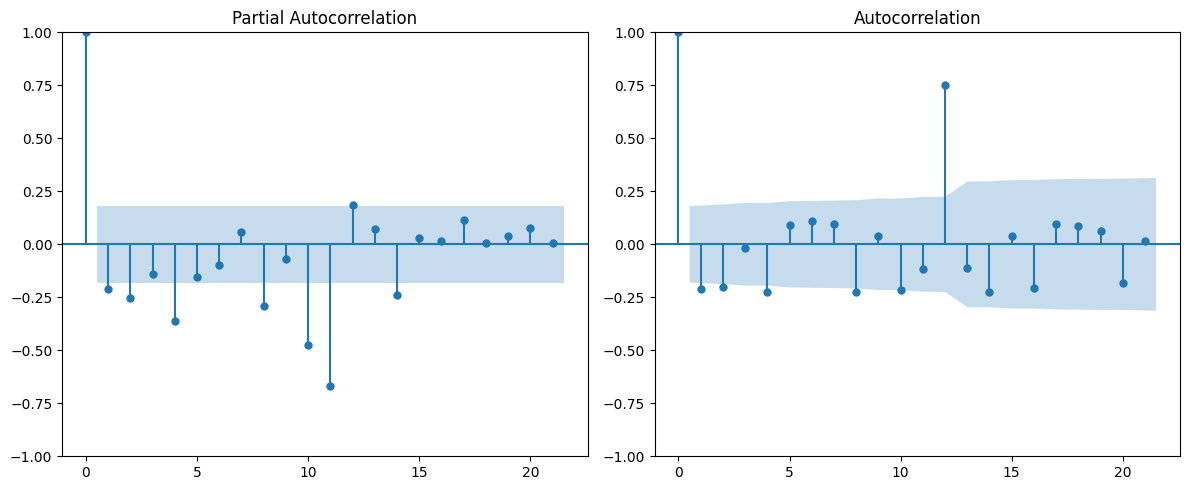

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train_data_diff_1 = train_data.diff().dropna()
train_data_diff_2 = train_data_diff_1.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_pacf(train_data_diff_2, ax=axes[0])
plot_acf(train_data_diff_2, ax=axes[1])
plt.tight_layout()
plt.show()
# p=1, q=1

In [15]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(train_data, order=(1, 2, 1))
ARIMA_result = ARIMA_model.fit()
print(ARIMA_result.summary())

                               SARIMAX Results                                
Dep. Variable:             passengers   No. Observations:                  120
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -560.986
Date:                Mon, 12 May 2025   AIC                           1127.973
Time:                        13:33:19   BIC                           1136.285
Sample:                    01-01-1949   HQIC                          1131.348
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2938      0.110      2.665      0.008       0.078       0.510
ma.L1         -0.9998      6.132     -0.163      0.870     -13.019      11.019
sigma2       761.4616   4699.689      0.162      0.8

/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


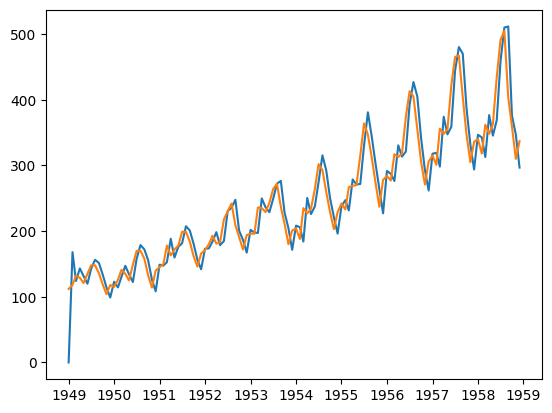

In [16]:
plt.plot(ARIMA_result.predict(), label='predict')
plt.plot(train_data, label='train')

/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


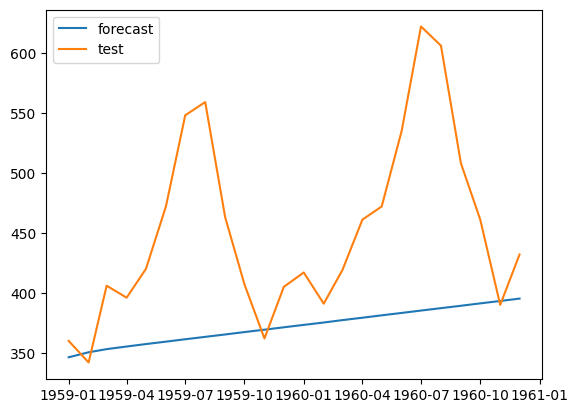

In [17]:
forecast_df = ARIMA_result.forecast(steps=len(test_data),alpha=0.05)
pred_y = forecast_df

plt.plot(forecast_df, label='forecast')
plt.plot(test_data, label='test')
plt.legend()
plt.show()

In [18]:
from pmdarima import auto_arima

auto_model = auto_arima(
    train_data,
    d=1,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=3,
    start_Q=0, max_Q=3,
    m=12,
    seasonal=True,
    information_criterion='aic',
    trace=True
)

print(
f'''
AIC : {auto_model.aic()}
BIC : {auto_model.bic()}
p,q,d : {auto_model.order}
P,Q,D : {auto_model.seasonal_order}
'''
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=807.655, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.973, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=805.408, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=803.281, Time=0.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=805.044, Time=0.05 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=805.093, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=804.813, Time=0.03 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=803.650, Time=0.01 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=806.793, Time=0.03 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=805.281, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.524 seconds

AIC : 803.2812826905046
BIC : 808.6269403594283
p,q,d : (1, 1, 0)
P,Q,D : (0, 1, 0, 12)



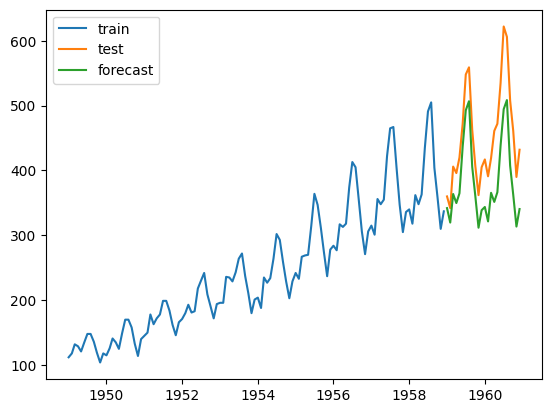

In [19]:
auto_pred_y = pd.DataFrame(auto_model.predict(n_periods=len(test_data)), index=test_data.index, columns=['price'])
plt.plot(train_data, label='train')
plt.plot(test_data, label='test')
plt.plot(auto_pred_y, label='forecast')
plt.legend()
plt.show()

In [20]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(train_data, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
ARIMA_result = ARIMA_model.fit()

/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


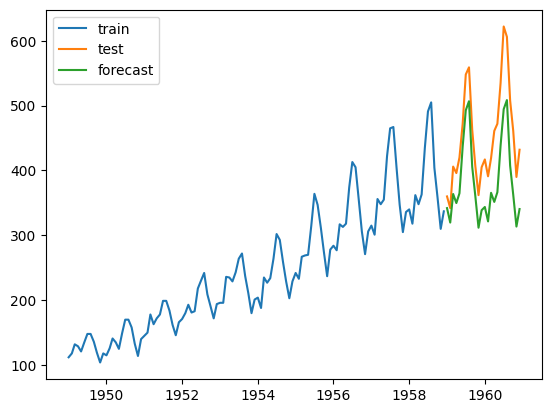

In [21]:
pred_y = ARIMA_result.predict(start=test_data.index[0], end=test_data.index[-1])
plt.plot(train_data, label='train')
plt.plot(test_data, label='test')
plt.plot(pred_y, label='forecast')
plt.legend()
plt.show()

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 최적 파라미터 추출
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# SARIMAX 피팅
sarimax_model = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
).fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33035D+00    |proj g|=  1.50687D-03

At iterate    5    f=  3.33034D+00    |proj g|=  1.56689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   4.314D-06   3.330D+00
  F =   3.3303386778771022     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/general/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


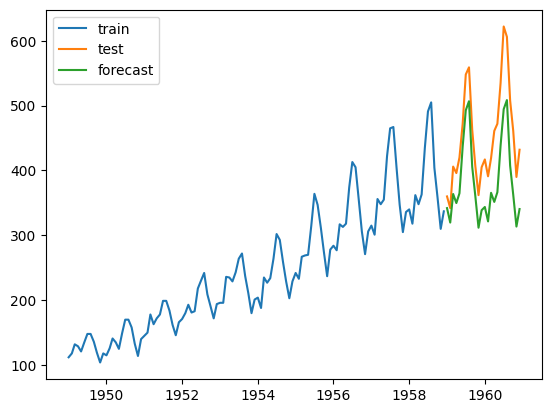

In [23]:
pred_y = sarimax_model.predict(start=test_data.index[0], end=test_data.index[-1])
plt.plot(train_data, label='train')
plt.plot(test_data, label='test')
plt.plot(pred_y, label='forecast')
plt.legend()
plt.show()